In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pickle

with open('zipcode.pickle', 'rb') as handle:
    zips = pickle.load(handle)

In [101]:
# %%writefile kmeans.py

import numpy as np

class Kmeans:
    """Customized K-means class to use alternative cost functions."""
   
    def __init__(self, data, distance_function):
        self._distance_function = distance_function
        self.nPoints = len(data)
        self.__initDataMatrix(data)
        
        
    def __initDataMatrix(self, data):
        self._index = {}
        self._matrix = np.zeros((self.nPoints , 2))
        count = 0
        for key, value in data.items():
            self._index[key] = count
            self._matrix[count,:] = value
            count += 1
       
        
    def startK(self, n, method = 'K++'):
        self._K = None
        if(method == 'random'):
            self.__randomStart(n)
       
        elif(method == 'K++'):
            self.__ppStart(n)
       
        return self._K
    
    
    def __randomStart(self, n):
        self._K = np.zeros((n, 2))
        for i in range(n):
            row = np.random.randint(low=0, high=self.nPoints)       
            self._K[i,:] = (self._matrix[row,:])
    
    
    def __ppStart(self, n):
        self._K = np.zeros((n, 2))
        
        p0 = self._matrix[np.random.randint(low=0, high=self.nPoints),:]
        self._K[0,:] = p0
        
        for k in range(1, n):
            distVec = self.distClosestPoint(p0)[:,1]
        
            distVec = np.power(distVec, 2)
            probVec = distVec / np.sum(distVec)
            cumProbVec = np.cumsum(probVec)
        
            r = np.random.rand()
        
            for j,p in enumerate(cumProbVec):
                if r < p:
                    i = j
                    break
            self._K[k,:] = self._matrix[i,:]
            
            
    def fit(self, iterations = 1000):
        for i in range(iterations):
            lastK = self._K
            distVec, self._K = self.updateK()
            
            if(np.array_equal(lastK, self._K)):
                return i, distVec, self._K
            
        return i, distVec, self._K
            
            
    def updateK(self):
        distVec = self.distClosestPoint(self._K)
        
        updK = np.zeros_like(self._K)
        
        nPoints = [0] * len(self._K)
        
        for i in range(self.nPoints):
            k = int(distVec[i,0])
            updK[k,:] += self._matrix[i,:]
            nPoints[k] += 1            
        
        for i in range(len(self._K)):
            updK[i,:] /= nPoints[i]
            
#         self._K = updK
        
        return distVec, updK
        
        
    def vecMatDistancePoint(self, point):
        return np.apply_along_axis(self.pingCost, 1, self._matrix, point)        
        
    
    def pingCost(self, p1, p2):
        return self._distance_function(p1, p2)
    
    
    ''' 
        Returns a matrix where first column is the closest point and seconde column is 
        the distance and each row is respective to the same row in the data maxtrix
    '''
    def distClosestPoint(self, pointList):
        n = len(pointList)
        mat = np.zeros((self.nPoints, n))
        
        for i in range(n):
            distVec = self.vecMatDistancePoint(pointList[i])
            mat[:,i] = distVec
            
        out = np.zeros((self.nPoints, 2))
        
        # TO DO: maybe find a way to iterate only once and get index and distance
        out[:,0] = np.argmin(mat, axis=1)
        out[:,1] = np.amin(mat, axis=1)
        return out
    
    
    @property
    def matrix(self):
        return self._matrix
    
    @property
    def K(self):
        return self._K
    
    def getPoints(self, key):
        return self._matrix[self._index[key]]
       

Overwriting kmeans.py


In [90]:
# %%writefile cost_functions.py

from scipy.spatial import distance

def euclidean(p1, p2):
    return distance.euclidean(p1, p2)

Writing cost_functions.py


In [91]:
# %%writefile util.py

# TO DO: This function needs to be improved right now is iterating one time for each cluster

def plotResult(m, k, distVec):
    cluster = [[],[]]

    styles = ['bo', 'go', 'co', 'mo', 'yo', 'ko', 'ro', 'bs', 'gs', 'cs', 'ms', 'ys', 'ks', 'rs']

    for j in range(len(k)):
        for i in range(len(m)):
            if(distVec[i] == j):
                cluster[0].append(m[i,0])
                cluster[1].append(m[i,1])

            plt.plot(cluster[0], cluster[1], styles[j])
            cluster = [[],[]]

    plt.plot(k[:, 0].flatten(),k[:, 1].flatten(), 'r^')

Writing util.py


In [96]:
test = Kmeans(zips, euclidean)

t = test.startK(4)

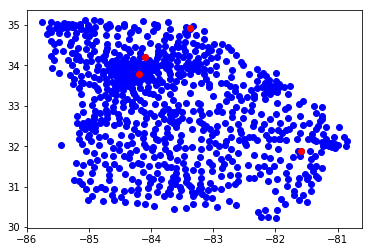

In [97]:
m = test.matrix
plt.plot(m[:, 0].flatten(),m[:, 1].flatten(), 'bo', t[:, 0].flatten(),t[:, 1].flatten(), 'ro')

In [98]:
ite, distVec, tf = test.fit()

Iterations:  9
AVG distance:  0.770426740015


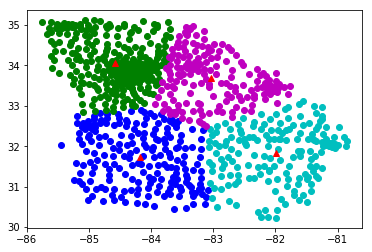

In [100]:
print("Iterations: ", ite)
print("AVG distance: ", np.mean(distVec[:,1]))

plotResult(m, tf, distVec[:,0])